# Generate Art using one style image

## Summary

In this project, I have tried to generate art on my own image by following the tutorial of [Siraj Raval's video](https://www.youtube.com/watch?v=Oex0eWoU7AQ&list=PL2-dafEMk2A7YdKv4XfKpfbTH5z6rEEj3&index=15).

## Things I have learnt from this project

* I learnt about importance of Content loss, Style loss and Total variation loss.
* How to extract features from the layer of any pre trained model.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread,imshow
from skimage.transform import resize
from keras import backend as K
from PIL import Image

#### Load and preprocess the style and content image

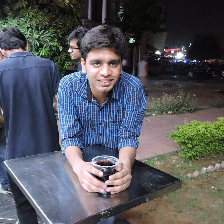

In [72]:
height = 224
width = 224

content_image_path = './sh.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

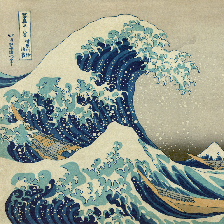

In [73]:
style_image_path = './wave.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))
style_image

In [74]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 224, 224, 3)
(1, 224, 224, 3)


For this, we need to perform two transformations:
* Subtract the mean RGB value (computed previously on the ImageNet training set and easily obtainable from Google searches) from each pixel.
* Flip the ordering of the multi-dimensional array from RGB to BGR (the ordering used in the paper).

In [75]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [76]:
content_array

array([[[[-102.68000031,  -99.77899933,  -87.93900299],
         [ -99.68000031,  -96.77899933,  -84.93900299],
         [-105.68000031, -102.77899933,  -90.93900299],
         ..., 
         [-106.68000031, -105.77899933,  -87.93900299],
         [-105.68000031, -104.77899933,  -86.93900299],
         [-105.68000031, -104.77899933,  -86.93900299]],

        [[-102.68000031,  -99.77899933,  -87.93900299],
         [-108.68000031, -105.77899933,  -93.93900299],
         [-102.68000031,  -99.77899933,  -87.93900299],
         ..., 
         [-107.68000031, -106.77899933,  -88.93900299],
         [-105.68000031, -104.77899933,  -86.93900299],
         [-105.68000031, -104.77899933,  -86.93900299]],

        [[-102.68000031,  -99.77899933,  -87.93900299],
         [-105.68000031, -102.77899933,  -90.93900299],
         [-101.68000031,  -98.77899933,  -86.93900299],
         ..., 
         [-106.68000031, -105.77899933,  -87.93900299],
         [-105.68000031, -104.77899933,  -86.93900299],

Now we're ready to use these arrays to define variables in Keras' backend (the TensorFlow graph). We also introduce a placeholder variable to store the combination image that retains the content of the content image while incorporating the style of the style image.

In [77]:
content_image = K.variable(content_array)
style_image = K.variable(style_array)
combination_image = K.placeholder((1, height, width, 3))

Finally, we concatenate all this image data into a single tensor that's suitable for processing by Keras' VGG16 model.

In [78]:
input_tensor = K.concatenate([content_image, style_image ,combination_image],axis = 0)

#### Reuse a model pre-trained for image classification to define loss functions

In [79]:
from keras.applications import vgg16

#include_top=False in the code below, we don't include any of the fully connected layers.

model = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
print('model loaded')

model loaded


* Keras has its own names for these layers. Let's make a list of these names so that we can easily refer to individual layers later.

In [80]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 224, 224, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_1/Relu:0' shape=(3, 224, 224, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_1/MaxPool:0' shape=(3, 112, 112, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 112, 112, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_1/Relu:0' shape=(3, 112, 112, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_1/MaxPool:0' shape=(3, 56, 56, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 56, 56, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_1/Relu:0' shape=(3, 56, 56, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_1/Relu:0' shape=(3, 56, 56, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_1/MaxPool:0' shape=(3, 28, 28, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_1/Relu:0' shape=(3, 28, 28, 512) dtype

* The relative importance of these terms are determined by a set of scalar weights. These are arbitrary, but the following set have been chosen after quite a bit of experimentation to find a set that generates output that's aesthetically pleasing to me.

In [81]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.

loss = K.variable(0.0)

#### Content loss

For the content loss, we follow Johnson et al. (2016) and draw the content feature from block2_conv2, because the original choice in Gatys et al. (2015) (block4_conv2) loses too much structural detail. And at least for faces, I find it more aesthetically pleasing to closely retain the structure of the original content image.

* The content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images.

In [82]:
def content_loss(content, combination):
    return K.sum(K.square(combination - content))

In [47]:
#layer_features = layers['block2_conv2']
#content_image_features = layer_features[0,:,:,:]
#combination_features = layer_features[2,:,:,:]

#loss += content_weight * content_loss(content_image_features, combination_features)

#### Style loss

For the style loss, we first define something called a Gram matrix. The terms of this matrix are proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together. By only capturing these aggregate statistics across the image, they are blind to the specific arrangement of objects inside the image. This is what allows them to capture information about style independent of content.

The Gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product.

In [83]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
    grams = K.dot(features, K.transpose(features))
    return grams

The style loss is then the (scaled, squared) Frobenius norm of the difference between the Gram matrices of the style and combination images.

Again, in the following code, I've chosen to go with the style features from layers defined in Johnson et al. (2016) rather than Gatys et al. (2015) because I find the end results more aesthetically pleasing. We can experiment with these choices to see varying results.

In [84]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height*width
    return (K.sum(K.square(S-C))/ (4. * (size**2) * (channels**2)))

In [85]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
loss2 = K.variable(0.)
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss2 += (style_weight / len(feature_layers)) * sl

#### Total variance loss

We were to solve the optimisation problem with only the two loss terms we've introduced so far (style and content), we'll find that the output is quite noisy. We thus add another term, called the total variation loss (a regularisation term) that encourages spatial smoothness

You can experiment with reducing the total_variation_weight and play with the noise-level of the generated image.

In [86]:
def total_variation_loss(x):
    a = K.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = K.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

#loss += total_variation_weight * total_variation_loss(combination_image)

* Selecting the layer for performing content loss

In [87]:
layer_features = layers['block2_conv2']
content_image_features = layer_features[0,:,:,:]
combination_features = layer_features[2,:,:,:]

* Total Loss

In [88]:
loss = [content_weight * content_loss(content_image_features, combination_features)] + loss2 + [total_variation_weight * total_variation_loss(combination_image)]

#### Define needed gradients and solve the optimisation problem

Defining the gradient

In [89]:
grads = K.gradients(loss, combination_image)

We then introduce an *Evaluator* class that computes loss and gradients in one pass while retrieving them via two separate functions, loss and grads. This is done because *scipy.optimize* requires separate functions for loss and gradients, but computing them separately would be inefficient.

In [90]:
outputs = [loss]
outputs += grads
f_output = K.function([combination_image],outputs)

def eval_loss_grad(x):
    x = x.reshape((1,height,width,3))
    outs =f_output([x])
    loss_value = outs[0]
    grad_value =outs[1].flatten().astype('float64')
    return loss_value, grad_value

In [91]:
class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.grad_value = None
        
    def loss(self,x):
        assert self.loss_value is None
        loss_values, grad_values = eval_loss_grad(x)
        self.loss_value = loss_values
        self.grad_value = grad_values
        return self.loss_value
    
    def grad(self,x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_value)
        self.loss_value = None
        self.grad_values = None
        return grad_values  

Now we're finally ready to solve our optimisation problem. This combination image begins its life as a random collection of (valid) pixels, and we use the **L-BFGS algorithm** (a quasi-Newton algorithm that's significantly quicker to converge than standard gradient descent) to iteratively improve upon it.

In [92]:
evaluator = Evaluator()

In [93]:
import time
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import copy

In [ ]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

Start of iteration 0
Current loss value: [  2.29766656e+10]
Iteration 0 completed in 165s
Start of iteration 1
Current loss value: [  1.47867822e+10]
Iteration 1 completed in 160s
Start of iteration 2
Current loss value: [  1.18526618e+10]
Iteration 2 completed in 161s
Start of iteration 3
Current loss value: [  1.04927427e+10]
Iteration 3 completed in 163s
Start of iteration 4
Current loss value: [  9.56775834e+09]
Iteration 4 completed in 160s
Start of iteration 5
Current loss value: [  8.93141402e+09]
Iteration 5 completed in 161s
Start of iteration 6
Current loss value: [  8.51582771e+09]
Iteration 6 completed in 159s
Start of iteration 7
Current loss value: [  8.13374822e+09]
Iteration 7 completed in 161s
Start of iteration 8
Current loss value: [  7.86239027e+09]
Iteration 8 completed in 163s
Start of iteration 9
Current loss value: [  7.63622195e+09]
Iteration 9 completed in 161s


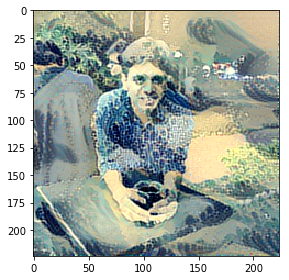

In [94]:
iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),fprime=evaluator.grad, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    
    x1 = copy.deepcopy(x)
    x1 = x1.reshape((height, width, 3))
    # Convert back from BGR to RGB to display the image
    x1 = x1[:, :, ::-1]
    x1[:, :, 0] += 103.939
    x1[:, :, 1] += 116.779
    x1[:, :, 2] += 123.68
    x1 = np.clip(x1, 0, 255).astype('uint8')
    imshow(x1)
    img_final = Image.fromarray(x1)
    img_final.save('result1' + str(i) + '.jpg')